In [1]:
import jax.numpy as jnp
from jax import jit
from jax.experimental.ode import odeint
import matplotlib.pyplot as plt

## Van der Pol Oscillator

In [2]:
def euler_method(f, y0, t, mu):
    """
    Solve an ODE using the Euler method

    Args:
        f (function): A function representing the ODE system
        y0 (array-like): The initial state of the system. This should be an array or list representing the initial values of the system's variables.
        t (array-like): An array of time points at which to evaluate the solution. The time points should be evenly spaced.
        mu (float): A parameter for the ODE system. This is specific to the Van der Pol oscillator in this context.

    Returns:
        array-like: An array containing the approximated solution of the ODE at each time point. 
        The shape is (len(t), len(y0)), where each row corresponds to the state of the system at a specific time, and each column corresponds to a component of the state vector.
    """
    y = jnp.zeros((len(t), len(y0)))
    # initialize the array to store solutions
    y = y.at[0].set(y0)
    dt = t[1] - t[0]
    for i in range(1, len(t)):
        y = y.at[i].set(y[i-1] + dt * f(y[i-1], t[i-1], mu))
    return y


## Euler Method + odeint()

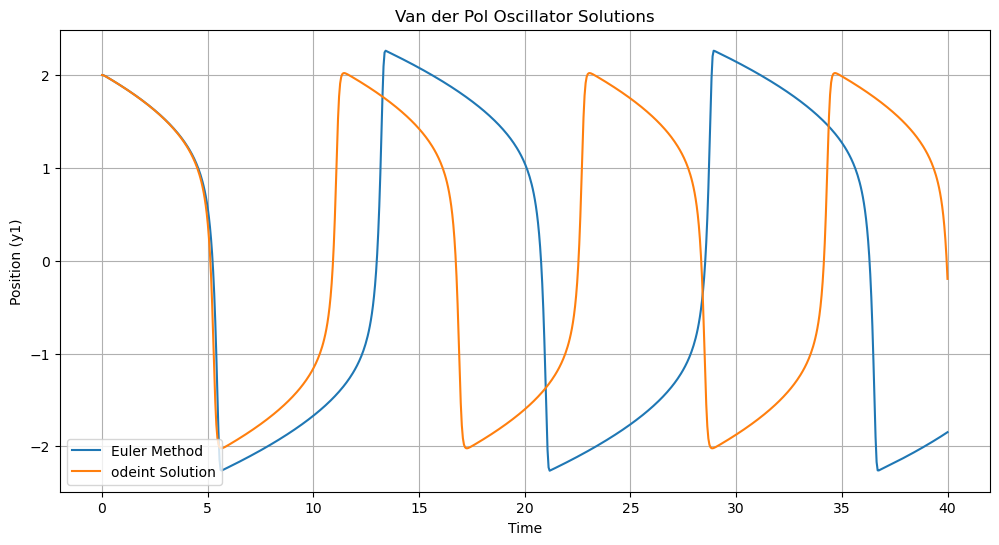

In [3]:
import jax.numpy as jnp
from jax.experimental.ode import odeint
import matplotlib.pyplot as plt

# define Van der Pol Oscillator
def vdp_oscillator(y, t, mu):
    y1, y2 = y
    dydt = jnp.array([y2, mu * (1 - y1**2) * y2 - y1])
    return dydt

# Parameters
mu = 5.0  # Non-linearity parameter
y0 = jnp.array([2.0, 0.0])  # Initial state (y, v)
t = jnp.linspace(0, 40, 800)  # Time from 0 to 40

# Solve the ODE using odeint
sol_odeint = odeint(vdp_oscillator, y0, t, mu)

# Solve the ODE using Euler's method
sol_euler = euler_method(vdp_oscillator, y0, t, mu)

# Combined plotting
plt.figure(figsize=(12, 6))

# Plot results
plt.plot(t, sol_euler[:, 0], label='Euler Method')
plt.plot(t, sol_odeint[:, 0], label='odeint Solution')
plt.title('Van der Pol Oscillator Solutions')
plt.xlabel('Time')
plt.ylabel('Position (y1)')
plt.legend()
plt.grid(True)
plt.show()


## Runge-Kutta

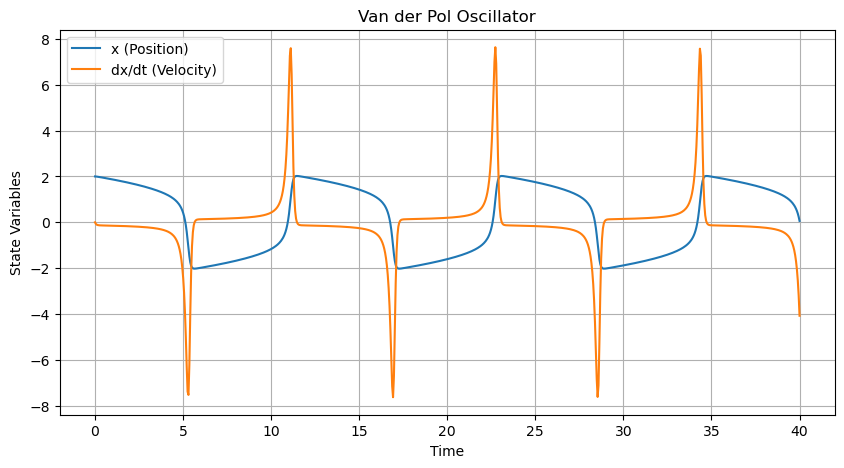

In [4]:
# RK4 Step function
def rk4_step(f, y, t, dt, mu):
    """
    Perform a single step of the RK4 integration for the Van der Pol oscillator.

    Parameters:
    - f: The derivative function of the system, f(y, t, mu)
    - y: Current value of the dependent variable
    - t: Current time
    - dt: Step size
    - mu: The mu parameter for the Van der Pol oscillator

    Returns:
    - y_next: Next value of y after a step dt
    """
    k1 = dt * f(y, t, mu)
    k2 = dt * f(y + 0.5 * k1, t + 0.5 * dt, mu)
    k3 = dt * f(y + 0.5 * k2, t + 0.5 * dt, mu)
    k4 = dt * f(y + k3, t + dt, mu)
    y_next = y + (k1 + 2*k2 + 2*k3 + k4) / 6
    return y_next

# Initial conditions and parameters
y0 = jnp.array([2.0, 0.0])  # Initial state [x0, dx0/dt]
t0 = 0.0
mu = 5.0
steps = 800
range_ = 40
dt = range_ / steps

# Storage for plotting
times = jnp.linspace(t0, range_, steps)
ys = jnp.zeros((steps, 2))

# Running the RK4 integration
y = y0
for i in range(steps):
    ys = ys.at[i].set(y)
    y = rk4_step(vdp_oscillator, y, times[i], dt, mu)

# Plotting
plt.figure(figsize=(10, 5))
plt.plot(times, ys[:, 0], label='x (Position)')
plt.plot(times, ys[:, 1], label='dx/dt (Velocity)')
plt.title('Van der Pol Oscillator')
plt.xlabel('Time')
plt.ylabel('State Variables')
plt.legend()
plt.grid(True)
plt.show()


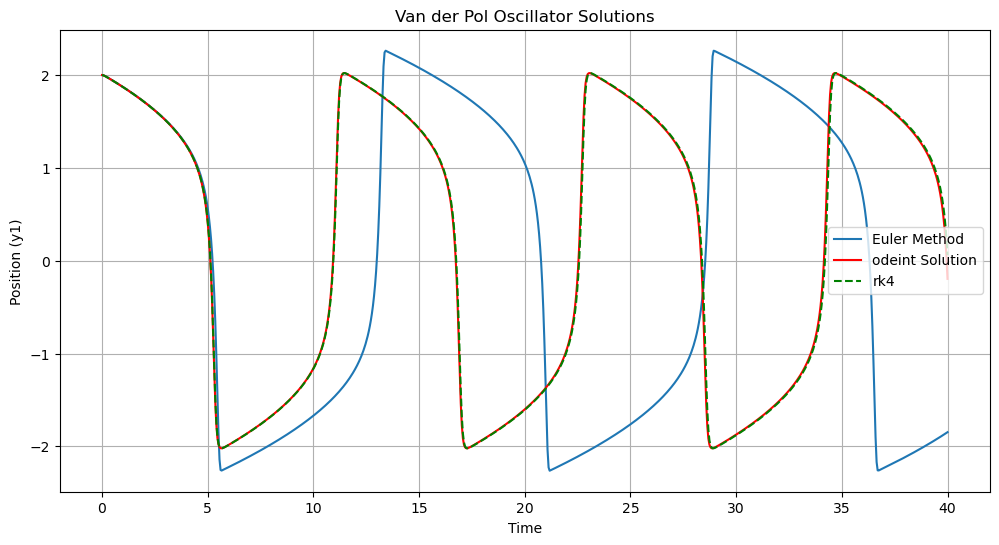

In [5]:
# Combined plotting
plt.figure(figsize=(12, 6))

# Plot results
plt.plot(t, sol_euler[:, 0], label='Euler Method')
plt.plot(t, sol_odeint[:, 0], label='odeint Solution', color = 'red')
plt.plot(t, ys[:, 0], '--', label='rk4', color = 'green')
plt.title('Van der Pol Oscillator Solutions')
plt.xlabel('Time')
plt.ylabel('Position (y1)')
plt.legend()
plt.grid(True)
plt.show()

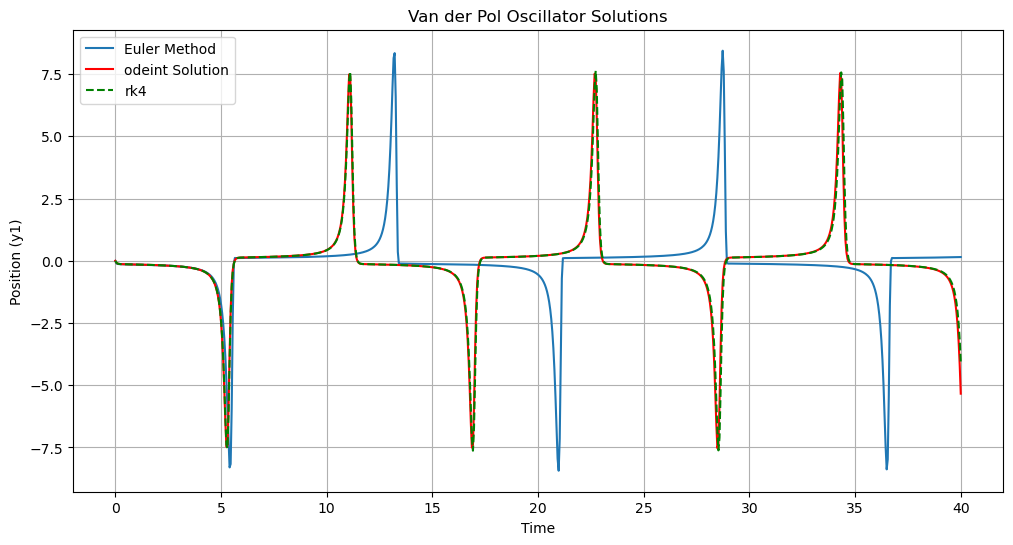

In [6]:
# Combined plotting
plt.figure(figsize=(12, 6))

# Plot results
plt.plot(t, sol_euler[:, 1], label='Euler Method')
plt.plot(t, sol_odeint[:, 1], label='odeint Solution', color = 'red')
plt.plot(t, ys[:, 1], '--', label='rk4', color = 'green')
plt.title('Van der Pol Oscillator Solutions')
plt.xlabel('Time')
plt.ylabel('Position (y1)')
plt.legend()
plt.grid(True)
plt.show()

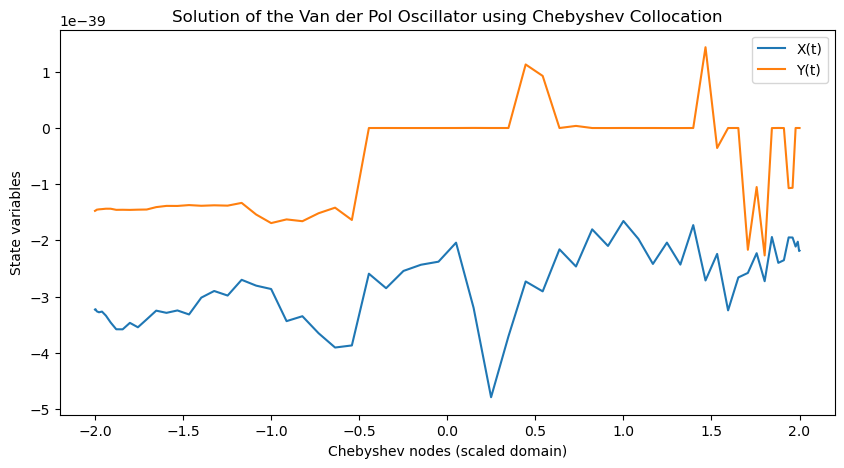

In [11]:
import jax.numpy as jnp
from jax import jit
from scipy.optimize import fsolve
import numpy as np

class ChebyshevCollocation:
    def __init__(self, n, domain=(-1, 1)):
        self.n = n
        self.domain = domain
        self.mesh = self.create_mesh(n)
        self.D = self.create_derivative_matrix(n)
        self.scale, self.shift = (domain[1] - domain[0]) / 2, (domain[1] + domain[0]) / 2

    @staticmethod
    def create_mesh(n):
        return jnp.cos(jnp.pi * jnp.arange(n) / (n - 1))

    @staticmethod
    def create_derivative_matrix(n):
        x = jnp.cos(jnp.pi * jnp.arange(n) / (n - 1))
        c = jnp.where(jnp.logical_or(jnp.arange(n) == 0, jnp.arange(n) == n-1), 2.0, 1.0)
        X = jnp.tile(x, (n, 1))
        dX = X - X.T
        D = jnp.where(X == X.T, jnp.zeros_like(dX), c * (-1)**jnp.arange(n) / (c.T * dX))
        D = D - jnp.diag(jnp.sum(D, axis=1))
        return D

    def vdp_system(self, U_flat, mu):
        U = U_flat.reshape((2, self.n))
        X, Y = U[0], U[1]
        DX, DY = self.D @ X, self.D @ Y
        # Adjust the system to match the scaled domain
        F1 = DY - Y
        F2 = DX - mu * (1 - X**2) * Y + X
        return jnp.concatenate([F1, F2])

# Parameters
n = 64  # Increased number of Chebyshev nodes
mu = 5.0
domain = (-2, 2)  # Expanded domain to see more of the dynamics
colloc = ChebyshevCollocation(n, domain)

# Initial guess (linearly interpolating initial conditions)
initial_conditions = jnp.array([2.0, 0.0])  # Starting at X=2, Y=0
U_guess = jnp.vstack([jnp.linspace(initial_conditions[0], 0, n),
                      jnp.linspace(initial_conditions[1], 0, n)]).flatten()

# Solve the collocation equations using fsolve from SciPy
solution = fsolve(lambda U: colloc.vdp_system(U, mu).block_until_ready(), U_guess)

# Plot results
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
plt.plot(colloc.mesh * colloc.scale + colloc.shift, solution[:n], label='X(t)')
plt.plot(colloc.mesh * colloc.scale + colloc.shift, solution[n:], label='Y(t)')
plt.legend()
plt.title('Solution of the Van der Pol Oscillator using Chebyshev Collocation')
plt.xlabel('Chebyshev nodes (scaled domain)')
plt.ylabel('State variables')
plt.show()


#### Example from https://github.com/bruscalia/collocation

In [1]:
import numpy as np
from collocation import OrthogonalCollocation

In [8]:
def fun_1(x, y, dy, d2y, k):
    return d2y[0] + k * y[0] + 1

def bc_1(x, y, dy, d2y, k):
    return dy[0] - 1

k1 = 1.0
k2 = -1.0
k = [k1, k2]

In [9]:
n_points = 6

# Create problem
problem_1 = OrthogonalCollocation(fun_1, bc_1, n_points, 1, x0=0.0, x1=1.0)

# Initial estimation
y01 = np.zeros([1, n_points + 1])

# Collocation using scipy.optimize.root in backend
problem_1.collocate(y01, args=k, method="hybr", tol=1e-6)

ValueError: operands could not be broadcast together with shapes (2,) (7,) 